In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
# قائمة المسارات للمجلدات TRAIN و TEST
data_dirs = [
    r'/content/drive/MyDrive/blood/dataset2-master/dataset2-master/images/TRAIN',
    r'/content/drive/MyDrive/blood/dataset2-master/dataset2-master/images/TEST'
]

filepaths = []
labels = []

# مرّ على كل مجلد رئيسي (TRAIN و TEST)
for data_dir in data_dirs:
    folds = os.listdir(data_dir)  # المجلدات الفرعية (التي تمثل الفئات)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['ig', 'neutrophil']:
            continue
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

# دمج المسارات والتسميات في DataFrame
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)


In [ ]:
df

,filepaths,labels
0,/content/drive/MyDrive/blood/dataset2-master/d...,NEUTROPHIL
1,/content/drive/MyDrive/blood/dataset2-master/d...,NEUTROPHIL
2,/content/drive/MyDrive/blood/dataset2-master/d...,NEUTROPHIL
3,/content/drive/MyDrive/blood/dataset2-master/d...,NEUTROPHIL
4,/content/drive/MyDrive/blood/dataset2-master/d...,NEUTROPHIL
...,...,...
12439,/content/drive/MyDrive/blood/dataset2-master/d...,MONOCYTE
12440,/content/drive/MyDrive/blood/dataset2-master/d...,MONOCYTE
12441,/content/drive/MyDrive/blood/dataset2-master/d...,MONOCYTE
12442,/content/drive/MyDrive/blood/dataset2-master/d...,MONOCYTE


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# crobed image size
batch_size = 128
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 9955 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.


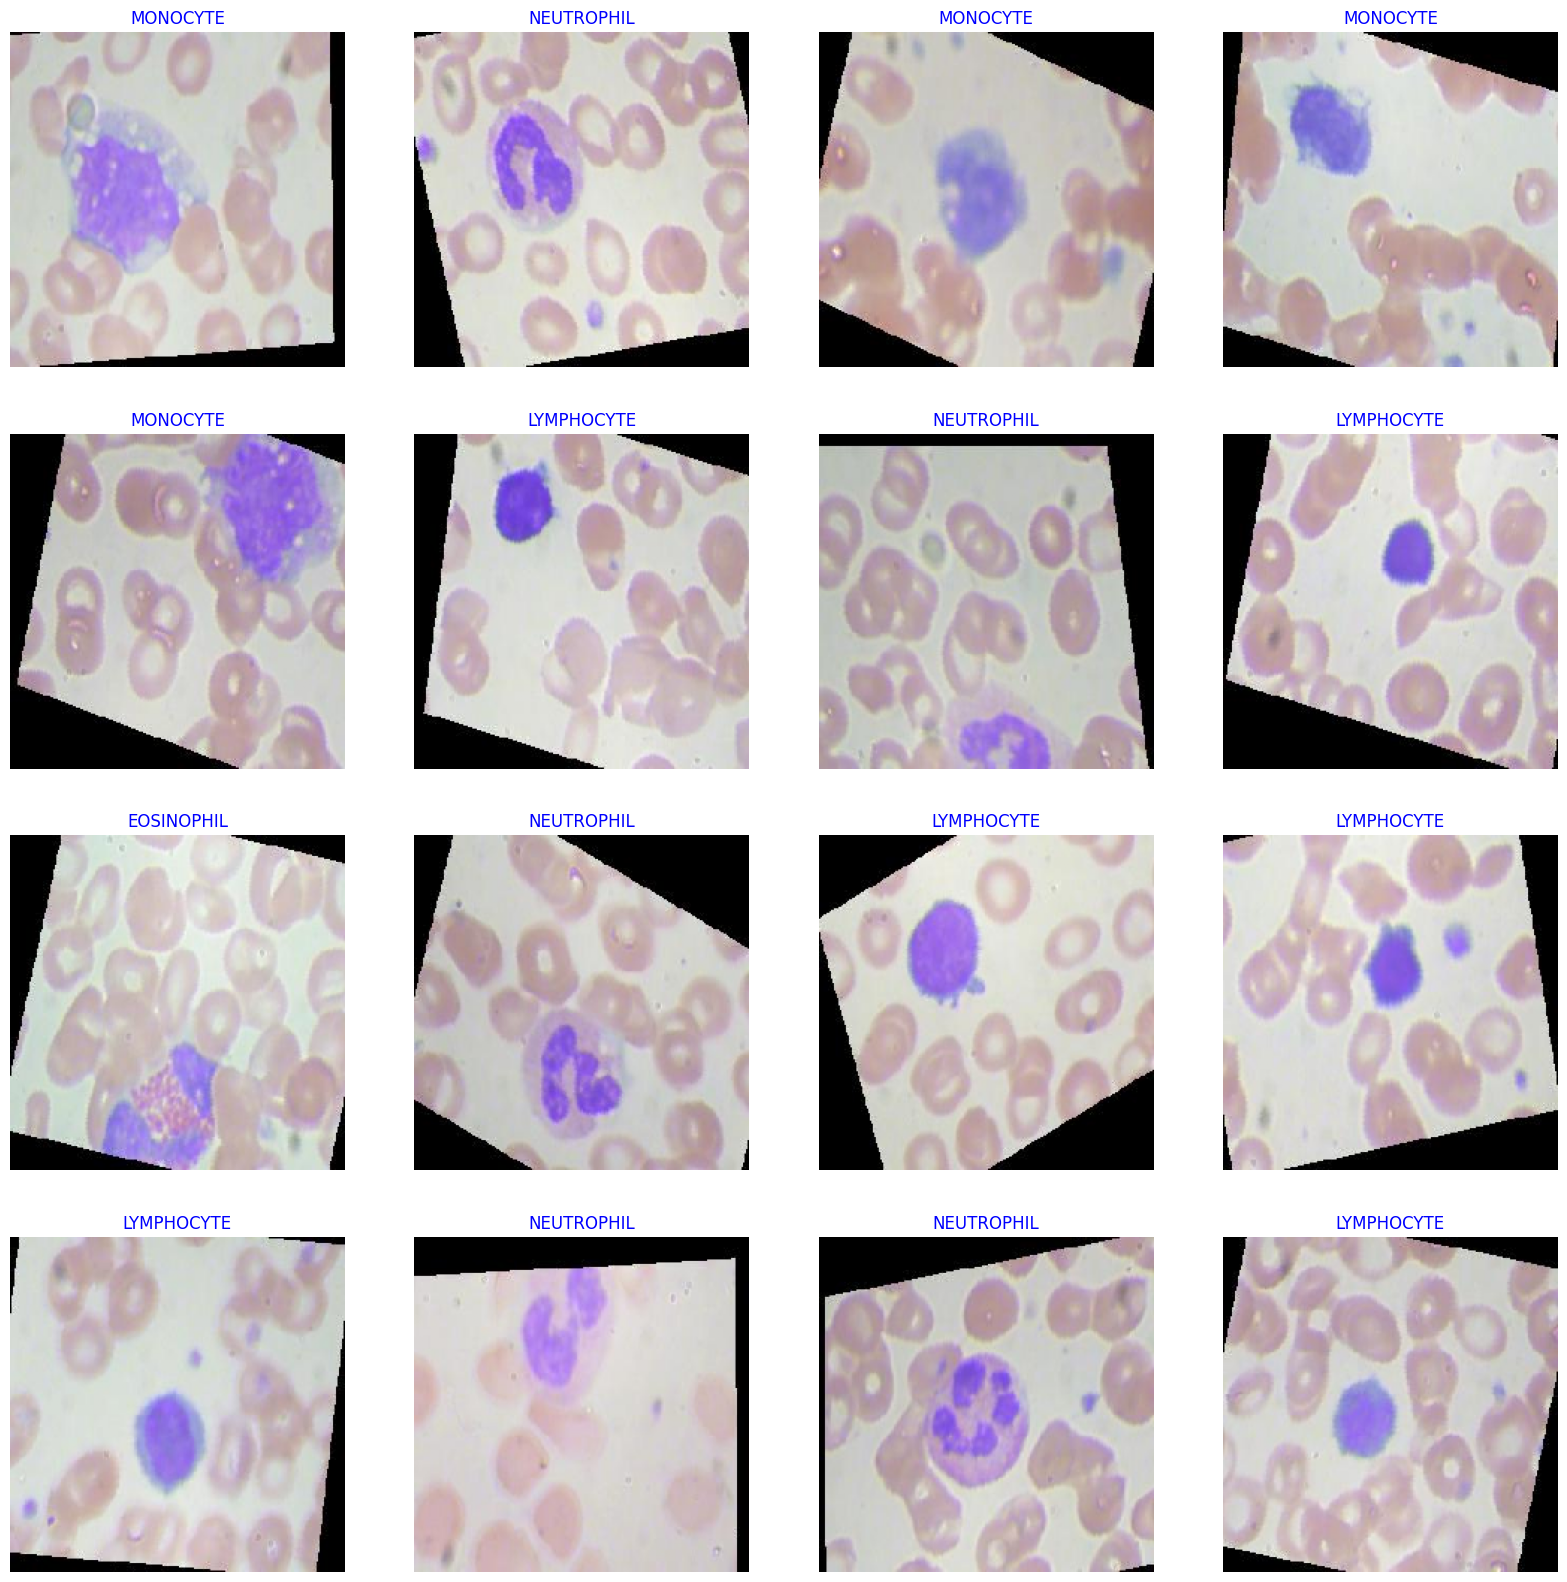

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(min(batch_size, 16)):  # Ensure the loop does not exceed the grid size (4x4)
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Define the input shape based on your image data
img_shape = (224, 224, 3)  # Adjust this based on your image size and number of channels

# Create the VGG16 base model
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_shape)

# Define the number of classes
class_count = len(list(train_gen.class_indices.keys()))  # Define the number of classes in the dense layer

# Create the full model
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Added BatchNormalization layer
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,238,852 (81.02 MB)

 Trainable params: 21,188,676 (80.83 MB)

 Non-trainable params: 50,176 (196.00 KB)

In [ ]:
# Ensure the model is defined
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3676s 46s/step - accuracy: 0.2536 - loss: 17.4305 - val_accuracy: 0.2518 - val_loss: 54197300.0000
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.2413 - loss: 4.7142 - val_accuracy: 0.2398 - val_loss: 457278.2812
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.2487 - loss: 2.8617 - val_accuracy: 0.2498 - val_loss: 1154.6825
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2567 - loss: 2.4541 - val_accuracy: 0.3175 - val_loss: 12.0573
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2495 - loss: 1.9042 - val_accuracy: 0.2773 - val_loss: 87120.6172
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.2559 - loss: 1.6879 - val_accuracy: 0.2646 - val_loss: 826.4047
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2490 - loss: 1.5614 - val_accuracy: 0.2512 - val_loss: 3693.2632
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2469 - loss: 1.466

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.applications import VGG16

# شكل الصور
img_shape = (224, 224, 3)

# عدد الفئات (من الجنريتور)
class_count = len(train_gen.class_indices)

# تحميل VGG16 بدون الرأس (include_top=False)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)

# فتح آخر 4 طبقات فقط للتدريب
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# بناء النموذج الكامل
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),  # من غير تنظيم مبالغ فيه
    Dropout(0.3),                    # تقليل dropout
    Dense(class_count, activation='softmax')
])

# تجميع النموذج
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# عرض ملخص النموذج
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,238,852 (81.02 MB)

 Trainable params: 13,553,412 (51.70 MB)

 Non-trainable params: 7,685,440 (29.32 MB)

In [ ]:
# Augmentation للتدريب فقط
tr_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# للتقييم والاختبار
ts_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# الجنريتور
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 9955 validated image filenames belonging to 4 classes.
Found 1493 validated image filenames belonging to 4 classes.
Found 996 validated image filenames belonging to 4 classes.


In [ ]:
epochs = 10
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=valid_gen,
                    verbose=1)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.5176 - loss: 1.1543 - val_accuracy: 0.8513 - val_loss: 0.6019
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8892 - loss: 0.3006 - val_accuracy: 0.8774 - val_loss: 0.3993
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9428 - loss: 0.1476 - val_accuracy: 0.9678 - val_loss: 0.1453
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9689 - loss: 0.0878 - val_accuracy: 0.9866 - val_loss: 0.0615
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9797 - loss: 0.0659 - val_accuracy: 0.9933 - val_loss: 0.0237
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.9778 - loss: 0.0609 - val_accuracy: 0.9812 - val_loss: 0.0490
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9832 - loss: 0.0537 - val_accuracy: 0.9866 - val_loss: 0.0409
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9872 - loss: 0.0384 - val_accuracy: 0.9826 - v

In [ ]:
# تقييم الأداء على مجموعة الاختبار
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 262s 37s/step - accuracy: 0.9938 - loss: 0.0183
Test Accuracy: 0.9910
Test Loss: 0.0226


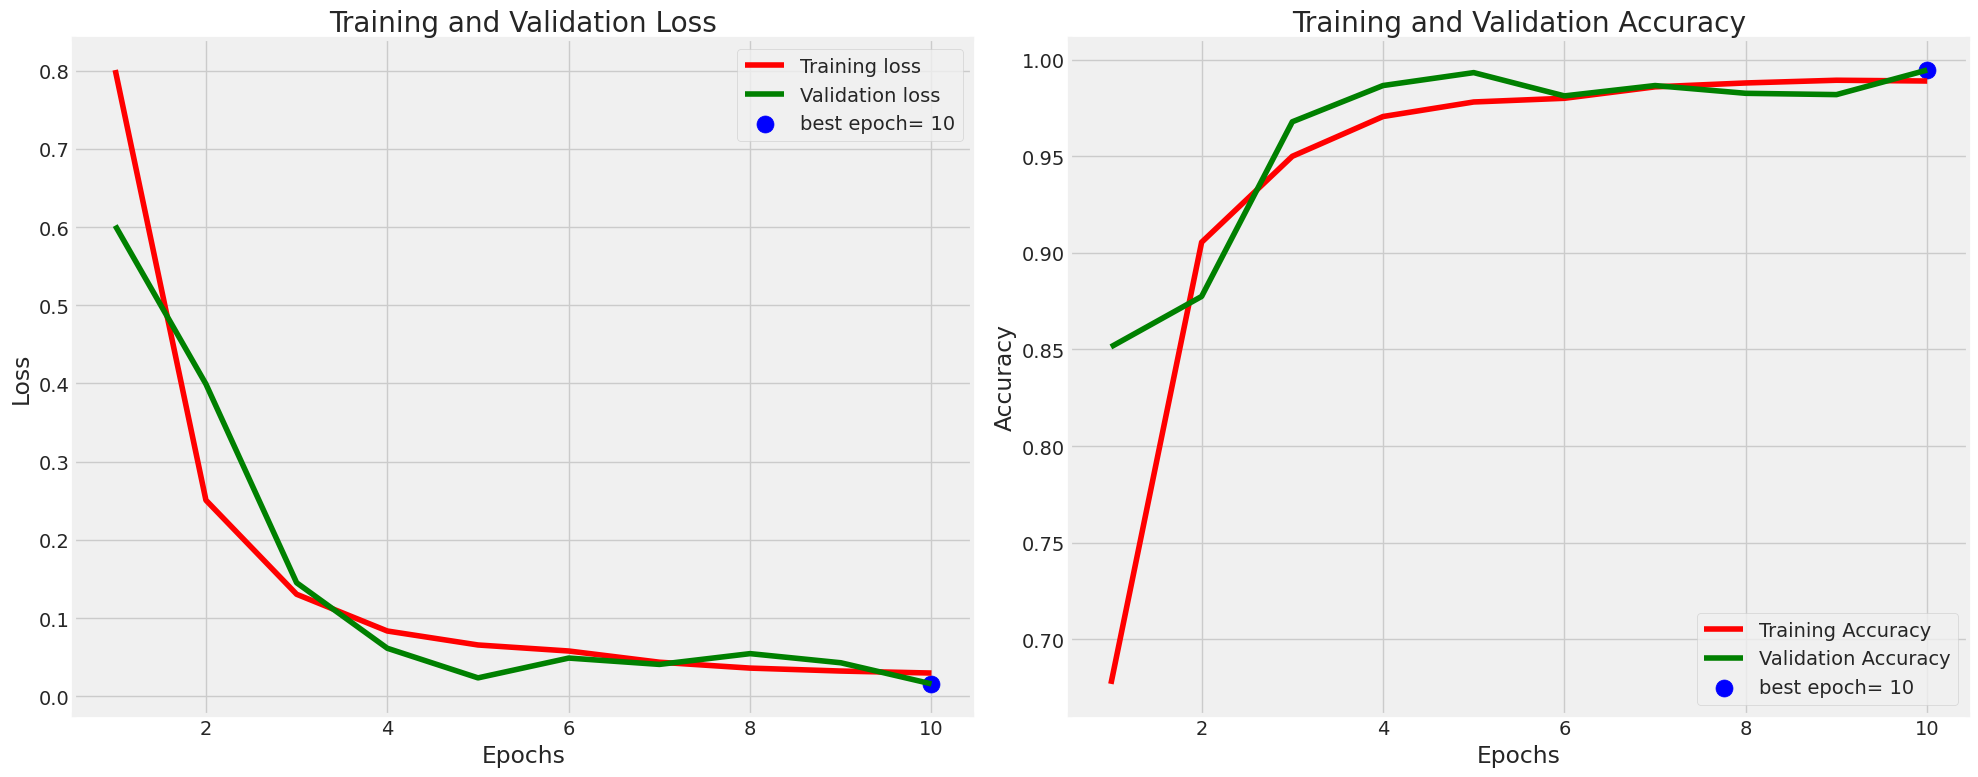

In [ ]:
# Ensure the model is trained
if 'history' not in globals():
	raise NameError("The variable 'history' is not defined. Please ensure that the cell containing the training code is executed.")

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

83/83 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9838 - loss: 0.0424
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9949 - loss: 0.0155  
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9913 - loss: 0.0221  
Train Loss:  0.03784474730491638
Train Accuracy:  0.9860371947288513
--------------------
Validation Loss:  0.015987150371074677
Validation Accuracy:  0.9946416616439819
--------------------
Test Loss:  0.022602180019021034
Test Accuracy:  0.990963876247406


In [ ]:
preds = model.predict(test_gen)  # يعمل بدون warning
y_pred = np.argmax(preds, axis=1)  # يجيب التوقعات على هيئة أرقام الفئات


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step


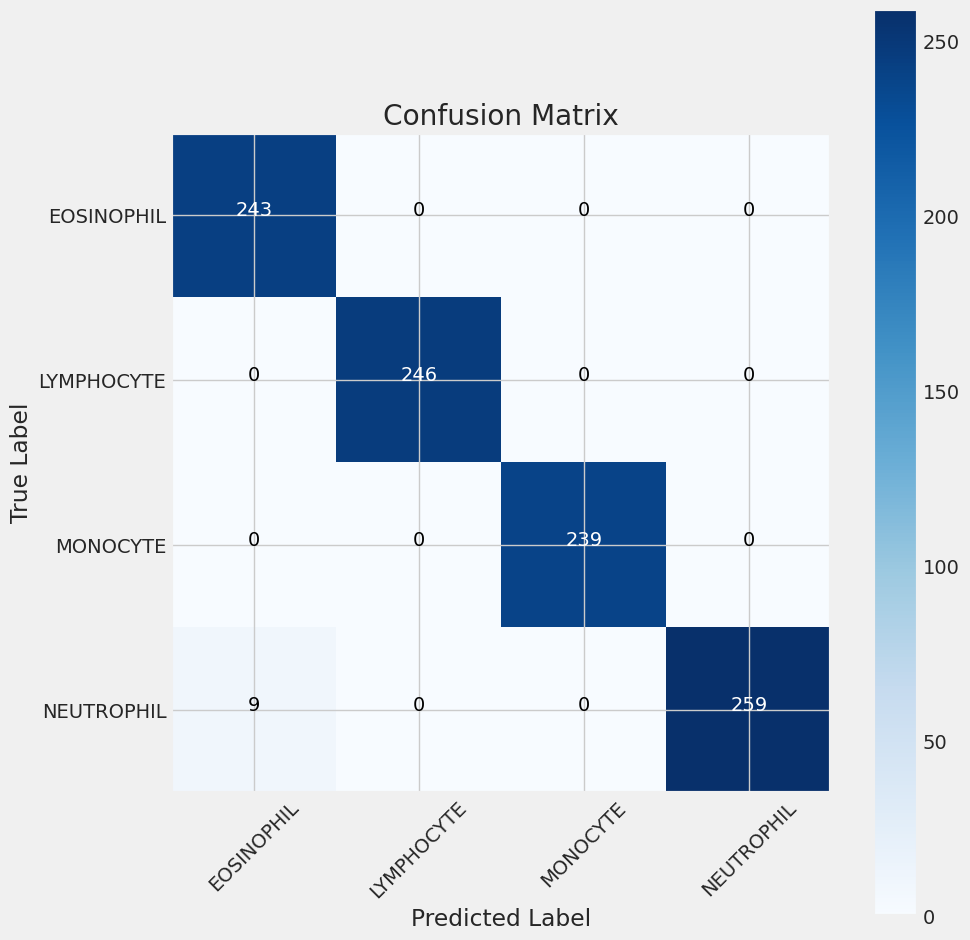

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

  EOSINOPHIL       0.96      1.00      0.98       243
  LYMPHOCYTE       1.00      1.00      1.00       246
    MONOCYTE       1.00      1.00      1.00       239
  NEUTROPHIL       1.00      0.97      0.98       268

    accuracy                           0.99       996
   macro avg       0.99      0.99      0.99       996
weighted avg       0.99      0.99      0.99       996



In [ ]:
#Save the model
model.save('Bloods.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/Bloods.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/drive/MyDrive/blood/dataset2-master/dataset2-master/images/TEST_SIMPLE/LYMPHOCYTE/_0_3975.jpeg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']  # Corrected here
score = tf.nn.softmax(predictions[0])

# Output the predicted class
print(f"{class_labels[tf.argmax(score)]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Lymphocyte


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

print("model converted")

# Save the model.
with open('Bloods.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpu1i8cbww'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_45')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139319413260112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413256848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413259152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413257808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413257232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413246864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413258000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413244368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413246672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139319413248784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13931941324